In [1]:
#!/usr/bin/python3
# -*- coding: utf8 -*-

import numpy as np
import tensorflow as tf
import os, random, shutil
np.random.seed(7)

FOLDER = '../data/'
train_data_dir = os.path.join(FOLDER, 'train')
val_data_dir = os.path.join(FOLDER, 'validation')
train_samples_num = 2250 # train set中全部照片数
val_samples_num = 250
IMG_W, IMG_H, IMG_CH = 150, 150, 3 # 单张图片的大小
batch_size = 16
epochs = 80 # 用比较少的epochs数目做演示，节约训练时间
class_num = 5 # 此处有5个类别

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# 2，准备训练集，tensorflow.keras有很多Generator可以直接处理图片的加载，增强等操作，封装的非常好
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( # 单张图片的处理方式，train时一般都会进行图片增强
    rescale=1. / 255, # 图片像素值为0-255，此处都乘以1/255，调整到0-1之间
    shear_range=0.2, # 斜切
    zoom_range=0.2, # 放大缩小范围
    horizontal_flip=True) # 水平翻转

train_generator = train_datagen.flow_from_directory( # 从文件夹中产生数据流
    train_data_dir, # 训练集图片的文件夹
    target_size=(IMG_W, IMG_H), # 调整后每张图片的大小
    batch_size=batch_size,
    class_mode='binary') # 此处是多分类问题，故而mode是categorical

# 3，同样的方式准备测试集
val_datagen = ImageDataGenerator(rescale=1. /
                                 255) # 只需要和trainset同样的scale即可，不需增强
val_generator = val_datagen.flow_from_directory(val_data_dir,
                                                target_size=(IMG_W, IMG_H),
                                                batch_size=batch_size,
                                                class_mode='binary')


Found 2250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [3]:
# 4，建立tensorflow.keras模型：模型的建立主要包括模型的搭建，模型的配置
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers


def build_model(input_shape):
    # 模型的搭建：此处构建三个CNN层+2个全连接层的结构
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=2, input_shape=input_shape))
    model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(Conv2D(64, (3, 3), strides=2))
    model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(Conv2D(64, (3, 3), strides=2))
    model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(Conv2D(64, (3, 3), strides=2))
    model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(Conv2D(32, (1, 1)))
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(Conv2D(16, (1, 1)))
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

#     model.add(Conv2D(64, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Flatten())
#     model.add(Dense(64))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5)) # Dropout防止过拟合
    model.add(Dense(class_num)) # 此处多分类问题，用Dense(class_num)
    model.add(Activation('softmax')) #多分类问题用softmax作为activation function

    # 模型的配置
    model.compile(
        loss='sparse_categorical_crossentropy', # 定义模型的loss func，optimizer，
        optimizer=optimizers.RMSprop(lr=1e-2, momentum=0.9), # 使用默认的lr=0.001
        metrics=['accuracy']) # 主要优化accuracy
    
    model.summary()

    return model # 返回构建好的模型


model = build_model(input_shape=(IMG_W, IMG_H, IMG_CH)) # 输入的图片维度

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 74, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        3

In [4]:
# 模型的训练
history_ft = model.fit(
    train_generator, # 数据流
    steps_per_epoch=train_samples_num // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_samples_num // batch_size)

Epoch 1/80
140/140 [==============================] - ETA: 0s - loss: 1.2947 - accuracy: 0.4625

/usr/lib/python3.8/site-packages/PIL/Image.py:988: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


140/140 [==============================] - 38s 271ms/step - loss: 1.2947 - accuracy: 0.4625 - val_loss: 4.8922 - val_accuracy: 0.2458
Epoch 2/80
140/140 [==============================] - 34s 241ms/step - loss: 1.2035 - accuracy: 0.5192 - val_loss: 4.8732 - val_accuracy: 0.2875
Epoch 3/80
140/140 [==============================] - 36s 258ms/step - loss: 1.1450 - accuracy: 0.5264 - val_loss: 7.8007 - val_accuracy: 0.2083
Epoch 4/80
140/140 [==============================] - 34s 246ms/step - loss: 1.1061 - accuracy: 0.5631 - val_loss: 2.7228 - val_accuracy: 0.2958
Epoch 5/80
140/140 [==============================] - 33s 237ms/step - loss: 1.0500 - accuracy: 0.6003 - val_loss: 4.3383 - val_accuracy: 0.1833
Epoch 6/80
140/140 [==============================] - 34s 243ms/step - loss: 1.0217 - accuracy: 0.6088 - val_loss: 2.1380 - val_accuracy: 0.3667
Epoch 7/80
140/140 [==============================] - 34s 246ms/step - loss: 0.9806 - accuracy: 0.6244 - val_loss: 2.1069 - val_accuracy: 0.2

140/140 [==============================] - 35s 251ms/step - loss: 0.4404 - accuracy: 0.8429 - val_loss: 3.1155 - val_accuracy: 0.3833
Epoch 58/80
140/140 [==============================] - 34s 245ms/step - loss: 0.4770 - accuracy: 0.8286 - val_loss: 0.5011 - val_accuracy: 0.8000
Epoch 59/80
140/140 [==============================] - 35s 253ms/step - loss: 0.4812 - accuracy: 0.8330 - val_loss: 1.0300 - val_accuracy: 0.7208
Epoch 60/80
140/140 [==============================] - 35s 252ms/step - loss: 0.4250 - accuracy: 0.8590 - val_loss: 0.8532 - val_accuracy: 0.7292
Epoch 61/80
140/140 [==============================] - 34s 245ms/step - loss: 0.4580 - accuracy: 0.8465 - val_loss: 0.5676 - val_accuracy: 0.8042
Epoch 62/80
140/140 [==============================] - 35s 251ms/step - loss: 0.4418 - accuracy: 0.8505 - val_loss: 0.6446 - val_accuracy: 0.7875
Epoch 63/80
140/140 [==============================] - 35s 248ms/step - loss: 0.4305 - accuracy: 0.8541 - val_loss: 0.9490 - val_accurac

In [5]:
tf.keras.models.save_model(model, "./simple.h5")

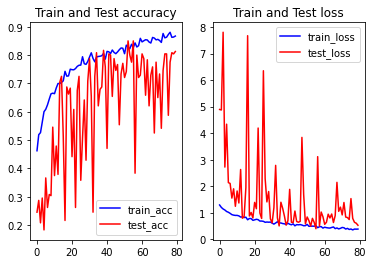

In [6]:
import matplotlib.pyplot as plt


def plot_training(history):
    plt.figure(12)

    plt.subplot(121)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(train_acc))
    plt.plot(epochs, train_acc, 'b', label='train_acc')
    plt.plot(epochs, val_acc, 'r', label='test_acc')
    plt.title('Train and Test accuracy')
    plt.legend()

    plt.subplot(122)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(train_loss))
    plt.plot(epochs, train_loss, 'b', label='train_loss')
    plt.plot(epochs, val_loss, 'r', label='test_loss')
    plt.title('Train and Test loss')
    plt.legend()

    plt.show()


plot_training(history_ft)
